In [1]:
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from collections import deque 
import torch
from torch.distributions import Categorical

In [2]:
gamma = 0.99
episodes = 2000
seed = 777

np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor,self).__init__()
        self.fc1 = nn.Linear(4,256)
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256,2)
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)
    
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        prob = nn.Softmax()(self.fc3(x))
        return prob
    
    def optimization(self, cost):
        self.optimizer.zero_grad()
        cost.backward()
        self.optimizer.step()

class Critic(nn.Module):
    def __init__(self):
        super(Critic,self).__init__()
        self.fc1 = nn.Linear(4,256)
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(), lr=5e-4)
    
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def optimization(self, cost):
        self.optimizer.zero_grad()
        cost.backward()
        self.optimizer.step()

In [4]:
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

def plot_durations(score_list,show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(score_list, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001) 
    
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

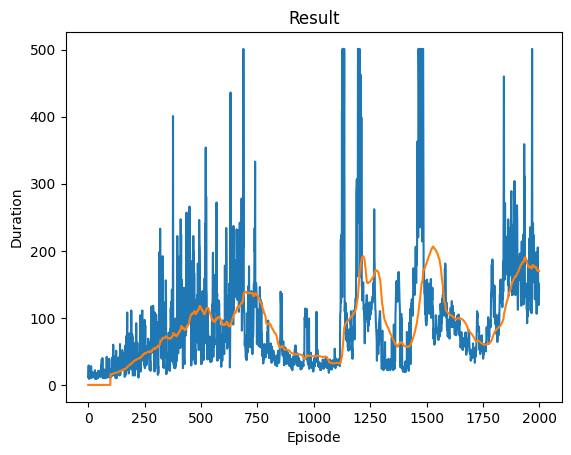

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
env = gym.make('CartPole-v1')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
critic_net = Critic().to(device)
actor_net = Actor().to(device)
score_list = []

for episode in range(episodes):
    state, _ = env.reset()
    done = False
    score = 0

    while not done:
        state = torch.tensor(state, device=device)

        prob = actor_net(state)
        distribution = Categorical(prob)
        action = distribution.sample()

        next_state, reward, done, truncated, _ = env.step(action.item())

        next_state = torch.tensor(next_state, device=device)

        done = done  or truncated
        done_num = 0 if done else 1
        
        delta = reward + gamma * critic_net(next_state) * done_num
        advantage =  delta.detach() - critic_net(state)

        actor_loss = - delta.detach() * torch.log(prob[action])
        critic_loss = advantage**2

        critic_net.optimization(critic_loss)
        actor_net.optimization(actor_loss)

        state = next_state

        score += reward
 
        if done:
            score_list.append(score + 1)
            plot_durations(score_list)
            break
    
    env.close()

plot_durations(score_list, show_result=True)
plt.ioff()
plt.show()


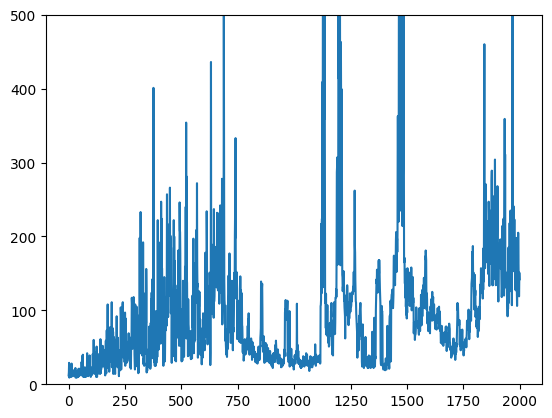

In [6]:
plot_durations(score_list)

plt.plot(score_list)
plt.ylim(0,500)
plt.show()